In [ ]:
from pytrends.request import TrendReq
import pandas as pd
from datetime import datetime, timedelta
import time
import yfinance as yf
import sqlite3
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import ta
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [28]:
def create_database():
    """
    Create SQLite database with tables for trends and market data
    """
    conn = sqlite3.connect('market_trends.db')
    cursor = conn.cursor()
    
    # Create table for Google Trends data
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS google_trends (
        date DATE,
        keyword TEXT,
        interest INTEGER,
        geo TEXT,
        PRIMARY KEY (date, keyword, geo)
    )
    ''')
    
    # Create table for S&P 500 data with trading day indicator
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS market_data (
        date DATE PRIMARY KEY,
        open REAL,
        high REAL,
        low REAL,
        close REAL,
        volume INTEGER,
        adjusted_close REAL,
        is_trading_day BOOLEAN
    )
    ''')
    
    conn.commit()
    conn.close()

def is_trading_day(date):
    """
    Check if a given date is a trading day
    
    Args:
        date (datetime): Date to check
        
    Returns:
        bool: True if trading day, False otherwise
    """
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=date, end=date)
    return (date.weekday() < 5) and (date not in holidays)

def get_previous_trading_day(date):
    """
    Get the most recent trading day before the given date
    
    Args:
        date (datetime): Reference date
        
    Returns:
        datetime: Previous trading day
    """
    current = date
    while True:
        current -= timedelta(days=1)
        if is_trading_day(current):
            return current

def get_next_trading_day(date):
    """
    Get the next trading day after the given date
    
    Args:
        date (datetime): Reference date
        
    Returns:
        datetime: Next trading day
    """
    current = date
    while True:
        current += timedelta(days=1)
        if is_trading_day(current):
            return current

def get_historical_trends(keyword, start_date, end_date, geo='', pause_time=1):
    """
    Fetch historical Google Trends data for a specific keyword
    
    Args:
        keyword (str): Search term to analyze
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'
        geo (str): Geographic location (default is worldwide)
        pause_time (int): Time to pause between requests to avoid rate limiting
    
    Returns:
        pandas.DataFrame: Historical trend data
    """
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        
        # Convert dates to datetime for processing
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        # Adjust start date to previous trading day if not a trading day
        if not is_trading_day(start_dt):
            start_dt = get_previous_trading_day(start_dt)
            
        # Adjust end date to next trading day if not a trading day
        if not is_trading_day(end_dt):
            end_dt = get_next_trading_day(end_dt)
        
        kw_list = [keyword]
        pytrends.build_payload(
            kw_list,
            cat=0,
            timeframe=f'{start_dt.strftime("%Y-%m-%d")} {end_dt.strftime("%Y-%m-%d")}',
            geo=geo
        )
        
        time.sleep(pause_time)
        
        trend_data = pytrends.interest_over_time()
        
        if trend_data.empty:
            print(f"No data found for keyword: {keyword}")
            return None
            
        trend_data = trend_data.drop(columns=['isPartial'])
        trend_data.reset_index(inplace=True)
        trend_data.rename(columns={keyword: 'interest'}, inplace=True)
        trend_data['keyword'] = keyword
        trend_data['geo'] = geo
        
        # Convert date column to datetime for processing
        trend_data['date'] = pd.to_datetime(trend_data['date'])
        
        # Add trading day indicator
        trend_data['is_trading_day'] = trend_data['date'].apply(is_trading_day)
        
        # Forward fill trends data to next trading day when current day is not a trading day
        non_trading_mask = ~trend_data['is_trading_day']
        trend_data.loc[non_trading_mask, 'date'] = trend_data.loc[non_trading_mask, 'date'].apply(get_next_trading_day)
        
        # Convert date back to string format
        trend_data['date'] = trend_data['date'].dt.strftime('%Y-%m-%d')
        
        return trend_data
        
    except Exception as e:
        print(f"Error fetching trends data for {keyword}: {str(e)}")
        return None

def get_sp500_data(start_date, end_date):
    """
    Fetch S&P 500 data from Yahoo Finance with proper handling of non-trading days
    
    Args:
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'
    
    Returns:
        pandas.DataFrame: S&P 500 historical data
    """
    try:
        # Convert dates to datetime
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        # Adjust date range to ensure we get data for the closest trading days
        adjusted_start = get_previous_trading_day(start_dt)
        adjusted_end = get_next_trading_day(end_dt)
        
        sp500 = yf.download('^GSPC', start=adjusted_start, end=adjusted_end)
        sp500.reset_index(inplace=True)
        
        # Create a complete date range including non-trading days
        date_range = pd.date_range(start=start_dt, end=end_dt, freq='D')
        complete_dates = pd.DataFrame({'date': date_range})
        
        # Merge market data with complete date range
        sp500['date'] = sp500['Date']
        sp500 = complete_dates.merge(sp500, on='date', how='left')
        
        # Forward fill missing values
        sp500 = sp500.fillna(method='ffill')
        
        # Add trading day indicator
        sp500['is_trading_day'] = sp500['date'].apply(is_trading_day)
        
        # Rename columns
        sp500.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume',
            'Adj Close': 'adjusted_close'
        }, inplace=True)
        
        # Drop original Date column
        sp500 = sp500.drop('Date', axis=1, errors='ignore')
        
        # Convert date to string format
        sp500['date'] = sp500['date'].dt.strftime('%Y-%m-%d')
        
        return sp500
        
    except Exception as e:
        print(f"Error fetching S&P 500 data: {str(e)}")
        return None

def save_to_database(trends_data, market_data, replace_existing=False):
    """
    Save both datasets to SQLite database
    
    Args:
        trends_data (pandas.DataFrame): Google Trends data
        market_data (pandas.DataFrame): S&P 500 data
        replace_existing (bool): If True, replace existing data
    """
    conn = sqlite3.connect('market_trends.db')
    
    if_exists = 'replace' if replace_existing else 'append'
    
    if trends_data is not None:
        # Drop duplicate dates for each keyword
        trends_data = trends_data.drop_duplicates(subset=['date', 'keyword', 'geo'])
        trends_data.to_sql('google_trends', conn, if_exists=if_exists, index=False)
        print("Trends data saved to database")
    
    if market_data is not None:
        # Drop duplicate dates
        market_data = market_data.drop_duplicates(subset=['date'])
        market_data.to_sql('market_data', conn, if_exists=if_exists, index=False)
        print("Market data saved to database")
    
    conn.close()

def query_combined_data(start_date=None, end_date=None, keywords=None, trading_days_only=True):
    """
    Query the database for combined trends and market data
    
    Args:
        start_date (str): Optional start date filter
        end_date (str): Optional end date filter
        keywords (list): Optional list of keywords to filter
        trading_days_only (bool): If True, return only trading days
    
    Returns:
        pandas.DataFrame: Combined data
    """
    conn = sqlite3.connect('market_trends.db')
    
    query = """
    SELECT 
        t.date,
        t.keyword,
        t.interest,
        m.close as sp500_close,
        m.volume as sp500_volume,
        m.adjusted_close as sp500_adjusted_close,
        m.is_trading_day
    FROM google_trends t
    LEFT JOIN market_data m ON t.date = m.date
    WHERE 1=1
    """
    
    if start_date:
        query += f" AND t.date >= '{start_date}'"
    if end_date:
        query += f" AND t.date <= '{end_date}'"
    if keywords:
        keywords_str = "','".join(keywords[:10])
        query += f" AND t.keyword IN ('{keywords_str}')"
    if trading_days_only:
        query += " AND m.is_trading_day = 1"
    
    query += " ORDER BY t.date, t.keyword"
    
    result = pd.read_sql_query(query, conn)
    conn.close()
    
    return result

def calculate_market_metrics(data, window=5):
    """
    Calculate additional market metrics
    
    Args:
        data (pandas.DataFrame): Combined market and trends data
        window (int): Rolling window size for calculations
    
    Returns:
        pandas.DataFrame: Data with additional metrics
    """
    metrics = data.copy()
    
    # Calculate returns
    metrics['daily_return'] = metrics.groupby('keyword')['sp500_close'].pct_change()
    
    # Calculate rolling metrics
    metrics['rolling_volatility'] = metrics.groupby('keyword')['daily_return'].transform(
        lambda x: x.rolling(window=window).std()
    )
    
    metrics['rolling_correlation'] = metrics.groupby('keyword').apply(
        lambda x: x['interest'].rolling(window=window).corr(x['daily_return'])
    ).reset_index(level=0, drop=True)
    
    return metrics

def fetch_and_store_data(keywords, start_date, end_date, geo='US', replace_existing=False, batch_size=5, pause_between_batches=60):
    """
    Fetch and store data for multiple keywords with improved handling of rate limits
    
    Args:
        keywords (list): List of keywords to analyze
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'
        geo (str): Geographic location (default is 'US')
        replace_existing (bool): If True, replace existing data
        batch_size (int): Number of keywords to process before pausing
        pause_between_batches (int): Seconds to pause between batches
    """
    # Create database and tables
    create_database()
    
    # Convert dates to datetime for validation
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Validate date range
    if start_dt >= end_dt:
        raise ValueError("End date must be after start date")
    
    # Fetch S&P 500 data once
    print("Fetching S&P 500 data...")
    market_data = get_sp500_data(start_date, end_date)
    if market_data is None:
        print("Failed to fetch market data. Aborting.")
        return None, None
    
    # Initialize an empty DataFrame for all trends data
    all_trends_data = pd.DataFrame()
    
    # Process keywords in batches
    for i in range(0, len(keywords), batch_size):
        batch_keywords = keywords[i:i + batch_size]
        print(f"\nProcessing batch {i//batch_size + 1} of {(len(keywords) + batch_size - 1)//batch_size}")
        
        # Fetch data for each keyword in the batch
        batch_trends = pd.DataFrame()
        for keyword in batch_keywords:
            try:
                print(f"Fetching data for keyword: {keyword}")
                trends_data = get_historical_trends(keyword, start_date, end_date, geo)
                if trends_data is not None:
                    batch_trends = pd.concat([batch_trends, trends_data], ignore_index=True)
                else:
                    print(f"Skipping {keyword} due to no data")
            except Exception as e:
                print(f"Error processing {keyword}: {str(e)}")
                continue
        
        # Add batch data to all trends data
        if not batch_trends.empty:
            all_trends_data = pd.concat([all_trends_data, batch_trends], ignore_index=True)
            
            # Optionally save each batch to database
            save_to_database(batch_trends, None, replace_existing if i == 0 else False)
        
        # Pause between batches if not the last batch
        if i + batch_size < len(keywords):
            print(f"Pausing for {pause_between_batches} seconds before next batch...")
            time.sleep(pause_between_batches)
    
    # Save market data to database
    save_to_database(None, market_data, replace_existing)
    
    print("\nData collection completed!")
    print(f"Total keywords processed: {len(keywords)}")
    print(f"Total trends data points: {len(all_trends_data)}")
    print(f"Market data points: {len(market_data)}")
    
    return all_trends_data, market_data

def main():
    # Comprehensive list of keywords grouped by category
    keywords = [
        # Market Direction Queries
        "will stock market crash",
        "is this a bear market",
        "when will bull market return",
        "should i buy stocks now",
        "is it time to buy stocks",
        "should i sell my stocks",
        "will market go up or down",
        "stock market bottom prediction",
        "how low will stocks go",
        "when to buy the dip",
        "is market going to crash",
        "stock market recovery 2024",
        
        # Economic Concern Queries
        "are we in a recession",
        "recession coming 2024",
        "how bad is inflation",
        "when will inflation end",
        "is inflation getting better",
        "unemployment rate today",
        "is economy getting better",
        "housing market crash coming",
        "will house prices drop",
        "job market outlook 2024",
        
        # Fed and Rates Queries
        "when will fed cut rates",
        "next fed meeting date",
        "what did powell say today",
        "fed interest rate decision",
        "will mortgage rates go down",
        "fed rate hike probability",
        "powell speech today",
        "when will rates go down",
        "fed meeting minutes",
        "interest rates forecast",
        
        # Popular Stock Queries
        "best stocks to buy now",
        "is tesla stock a buy",
        "amazon stock forecast",
        "apple stock prediction",
        "nvidia stock price target",
        "meta stock buy or sell",
        "microsoft stock outlook",
        "best ai stocks to buy",
        "chatgpt stocks to buy",
        "semiconductor stocks list",
        
        # Investment Strategy Queries
        "how to invest 10000",
        "best etfs to buy now",
        "safest investments 2024",
        "where to invest money",
        "dividend stocks list",
        "best index funds 2024",
        "how to buy sp500",
        "best performing etfs",
        "growth stocks to buy",
        "value stocks to buy",
        
        # Risk and Protection Queries
        "how to protect portfolio",
        "best hedge against crash",
        "safest place for money",
        "how to invest in gold",
        "bitcoin safe haven",
        "portfolio protection strategy",
        "best defensive stocks",
        "recession proof stocks",
        "how to buy bonds",
        "inflation protection investments",
        
        # Earnings and Corporate News
        "companies reporting earnings",
        "earnings calendar this week",
        "biggest stock movers today",
        "company layoffs 2024",
        "tech company layoffs",
        "retail sales numbers",
        "company bankruptcy news",
        "dividend cuts announced",
        "stock buyback announcements",
        "tech earnings today",
        
        # Trading Pattern Queries
        "stock market pattern today",
        "support and resistance levels",
        "stock chart analysis",
        "day trading patterns",
        "best trading indicators",
        "how to read stock charts",
        "stock momentum indicator",
        "trading volume meaning",
        "oversold stocks today",
        "overbought stocks list",
        
        # Market News Searches
        "stock market news today",
        "why is market down today",
        "why stocks are falling",
        "market crash news",
        "stock market live updates",
        "premarket trading today",
        "futures market now",
        "market after hours trading",
        "stock market summary",
        "market wrap today",
        
        # Alternative Investment Queries
        "how to buy bitcoin",
        "crypto market prediction",
        "real estate investment guide",
        "best reits to buy",
        "commodity prices today",
        "gold price prediction",
        "oil price forecast",
        "alternative investments list",
        "hedge fund returns",
        "private equity performance",
        
        # Global Market Queries
        "china stock market news",
        "european markets today",
        "emerging markets etf",
        "global market performance",
        "international stocks to buy",
        "foreign market hours",
        "world market indices",
        "currency exchange rates",
        "global recession risk",
        "international trade news",
        
        # Retail Trading Queries
        "robinhood stocks trending",
        "wallstreetbets stocks",
        "meme stocks today",
        "short squeeze stocks",
        "most shorted stocks",
        "options trading for beginners",
        "call options explained",
        "how to start day trading",
        "margin trading explained",
        "best trading apps",
        
        # Financial Health Indicators
        "credit card debt statistics",
        "consumer spending data",
        "retail store closings",
        "new business openings",
        "mortgage default rates",
        "car loan delinquencies",
        "housing starts data",
        "retail sales numbers",
        "online shopping trends",
        "consumer confidence index",
        
        # Original Keywords
        "Retail sales",
        "Black Friday deals",
        "Amazon stock price",
        "Walmart earnings",
        "Luxury goods sales",
        "Home buying",
        "Car sales",
        "Travel bookings",
        "Restaurant reservations"
    ]

    start_date = "2024-01-01"
    end_date = "2024-07-01"
    geo = "US"
    
    print(f"Starting data collection for {len(keywords)} keywords...")
    
    # Fetch and store data with improved batch processing
    trends_data, market_data = fetch_and_store_data(
        keywords,
        start_date,
        end_date,
        geo=geo,
        replace_existing=True,
        batch_size=3,  # Process 3 keywords at a time to avoid rate limits
        pause_between_batches=10  # Pause for 10 seconds between batches
    )
    
    if trends_data is not None and market_data is not None:
        # Query results for trading days only
        results = query_combined_data(start_date, end_date, keywords, trading_days_only=True)
        
        # Calculate additional metrics
        results_with_metrics = calculate_market_metrics(results)
        
        # Save results to CSV
        results_with_metrics.to_csv('market_trends_analysis.csv', index=False)
        print("\nResults saved to market_trends_analysis.csv")
        
        # Display summary statistics
        print("\nData Collection Summary:")
        print(f"Total keywords processed: {len(keywords)}")
        print(f"Total data points: {len(results_with_metrics)}")
        print(f"Date range: {start_date} to {end_date}")
        
        # Display sample of results
        print("\nSample of combined data with metrics:")
        print(results_with_metrics.head(15))
        
        # Calculate and display keyword coverage
        unique_keywords = results_with_metrics['keyword'].nunique()
        print(f"\nKeyword coverage: {unique_keywords}/{len(keywords)} ({(unique_keywords/len(keywords)*100):.1f}%)")
    else:
        print("Failed to fetch data. Please check the error messages above.")

if __name__ == "__main__":
    main()

Starting data collection for 141 keywords...
Fetching S&P 500 data...
[*********************100%***********************]  1 of 1 completed

Processing batch 1 of 47
Fetching data for keyword: will stock market crash
Fetching data for keyword: is this a bear market
Fetching data for keyword: when will bull market return
No data found for keyword: when will bull market return
Skipping when will bull market return due to no data
Trends data saved to database
Pausing for 10 seconds before next batch...

Processing batch 2 of 47
Fetching data for keyword: should i buy stocks now
Fetching data for keyword: is it time to buy stocks
Fetching data for keyword: should i sell my stocks
Trends data saved to database
Pausing for 10 seconds before next batch...

Processing batch 3 of 47
Fetching data for keyword: will market go up or down
Fetching data for keyword: stock market bottom prediction
Fetching data for keyword: how low will stocks go
No data found for keyword: how low will stocks go
Skipp

In [54]:
def get_analysis_data():
    """Retrieve data from SQLite database"""
    conn = sqlite3.connect('market_trends.db')
    
    query = """
    SELECT 
        t.date,
        t.keyword,
        t.interest,
        m.close as sp500_close
    FROM google_trends t
    LEFT JOIN market_data m ON t.date = m.date
    WHERE m.close IS NOT NULL
    ORDER BY t.date, t.keyword
    """

    # m.volume as sp500_volume,
    # m.adjusted_close as sp500_adjusted_close,
    # m.open as sp500_open,
    # m.high as sp500_high,
    # m.low as sp500_low
    
    results = pd.read_sql_query(query, conn)
    conn.close()
    
    print(f"Retrieved {len(results)} rows of data")
    print(f"Unique keywords: {len(results['keyword'].unique())}")
    print(f"Date range: {results['date'].min()} to {results['date'].max()}")
    
    return results

data = get_analysis_data()

Retrieved 10080 rows of data
Unique keywords: 80
Date range: 2024-01-02 to 2024-07-01


In [56]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Add technical analysis indicators to the price data"""
    df = df.sort_index()
    
    # Price based indicators
    df['returns'] = df['sp500_close'].pct_change()
    df['log_returns'] = np.log(df['sp500_close']).diff()
    
    # Moving averages
    for window in [5, 10, 20, 50]:
        df[f'sma_{window}'] = ta.trend.sma_indicator(df['sp500_close'], window=window)
        df[f'ema_{window}'] = ta.trend.ema_indicator(df['sp500_close'], window=window)
    
    # Momentum indicators
    df['rsi'] = ta.momentum.rsi(df['sp500_close'], window=14)
    df['macd'] = ta.trend.macd_diff(df['sp500_close'])
    
    # Volatility indicators
    bb_bands = ta.volatility.BollingerBands(df['sp500_close'])
    df['bb_high'] = bb_bands.bollinger_hband()
    df['bb_low'] = bb_bands.bollinger_lband()
    df['bb_pct_b'] = bb_bands.bollinger_pband()
    
    return df

data = add_technical_indicators(data)
display(data)


,date,keyword,interest,sp500_close,returns,log_returns,sma_5,ema_5,sma_10,ema_10,sma_20,ema_20,sma_50,ema_50,rsi,macd,bb_high,bb_low,bb_pct_b
0,2024-01-02,Restaurant reservations,67,4742.830078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,Retail sales,29,4742.830078,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-02,Travel bookings,0,4742.830078,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-02,Walmart earnings,0,4742.830078,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-02,alternative investments list,0,4742.830078,0.0,0.0,4742.830078,4742.830078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,2024-07-01,why stocks are falling,0,5475.089844,0.0,0.0,5475.089844,5475.089844,5475.089844,5475.089840,5475.089844,5475.082582,5475.089844,5474.434462,99.593681,-0.019637,5475.089844,5475.089844,NaN
10076,2024-07-01,will house prices drop,0,5475.089844,0.0,0.0,5475.089844,5475.089844,5475.089844,5475.089841,5475.089844,5475.083274,5475.089844,5474.460163,99.593681,-0.018191,5475.089844,5475.089844,NaN
10077,2024-07-01,will market go up or down,0,5475.089844,0.0,0.0,5475.089844,5475.089844,5475.089844,5475.089841,5475.089844,5475.083899,5475.089844,5474.484857,99.593681,-0.016852,5475.089844,5475.089844,NaN
10078,2024-07-01,will mortgage rates go down,36,5475.089844,0.0,0.0,5475.089844,5475.089844,5475.089844,5475.089842,5475.089844,5475.084466,5475.089844,5474.508582,99.593681,-0.015610,5475.089844,5475.089844,NaN



Preparing data for modeling...


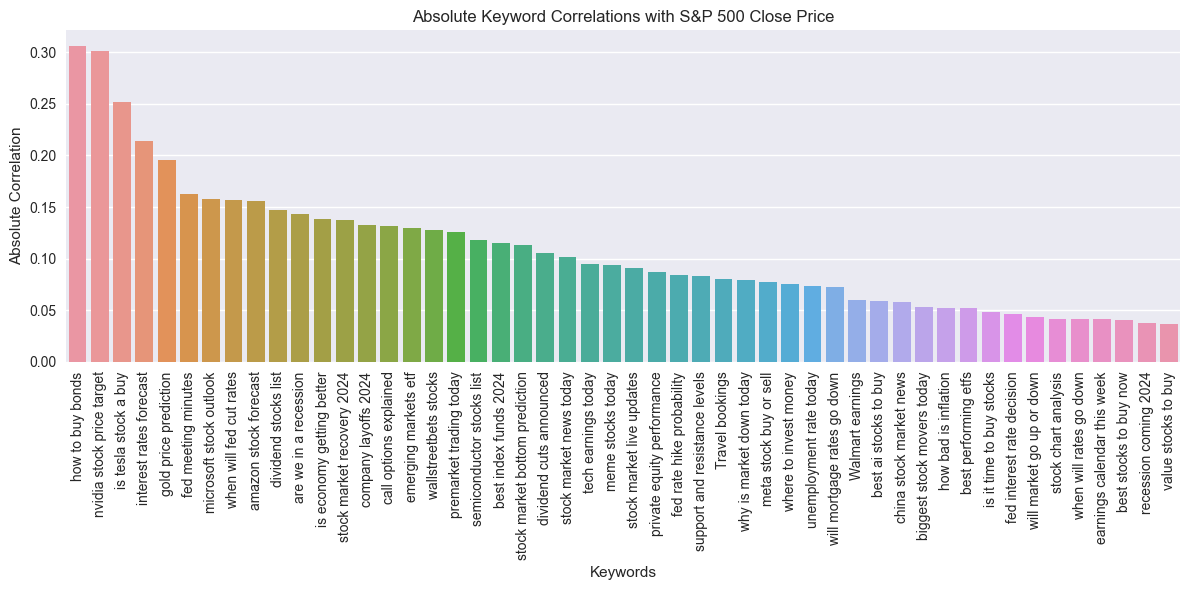

In [70]:
def prepare_data_for_modeling(data: pd.DataFrame, 
                            min_abs_correlation: float = 0.1,
                            forecast_horizon: int = 1) -> Tuple[pd.DataFrame, List[str]]:
    """Prepare data for modeling"""
    # Pivot trends data
    trends_pivot = data.pivot(index='date', columns='keyword', values='interest')
    
    # Prepare market data
    market_data = data[['date', 'sp500_close', 'returns', 'log_returns',
                        'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 
                        'ema_20', 'sma_50', 'ema_50', 'rsi', 'macd', 
                        'bb_high', 'bb_low', 'bb_pct_b']].drop_duplicates()
    market_data.set_index('date', inplace=True)
    
    # Combine market data with trends
    combined_data = pd.merge(trends_pivot, market_data, left_index=True, right_index=True)
    
    # Calculate correlations for feature selection (only for keywords)
    keyword_correlations = trends_pivot.corrwith(combined_data['sp500_close'])
    selected_features = keyword_correlations[abs(keyword_correlations) >= min_abs_correlation].index.tolist()
    
    # Visualize keyword correlations
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=keyword_correlations.abs().sort_values(ascending=False).iloc[:50].index, 
        y=keyword_correlations.abs().sort_values(ascending=False).iloc[:50].values
    )
    plt.xticks(rotation=90)
    plt.title('Absolute Keyword Correlations with S&P 500 Close Price')
    plt.ylabel('Absolute Correlation')
    plt.xlabel('Keywords')
    plt.tight_layout()
    plt.show()
    
    # Collect lagged features in a dictionary
    lagged_features = {}
    for col in selected_features:
        for lag in range(1, 6):
            lagged_features[f'{col}_lag_{lag}'] = trends_pivot[col].shift(lag)
    
    # Concatenate lagged features with the original DataFrame
    combined_data = pd.concat([combined_data, pd.DataFrame(lagged_features, index=combined_data.index)], axis=1)
    
    # Create target variable
    combined_data['target'] = combined_data['sp500_close'].shift(-forecast_horizon)
    
    # Drop rows with NaN values
    combined_data = combined_data.dropna()
    
    # Select features
    feature_cols = [col for col in combined_data.columns 
                   if col not in ['target', 'sp500_close']]
    
    return combined_data, feature_cols

print("\nPreparing data for modeling...")
prepared_data, feature_cols = prepare_data_for_modeling(
    data,
    min_abs_correlation=0.1,
    forecast_horizon=1
)


Training and evaluating model...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Evaluation Metrics:
Train MSE: 0.3719
Test MSE: 14347.8407
Train R²: 1.0000
Test R²: -1.1974


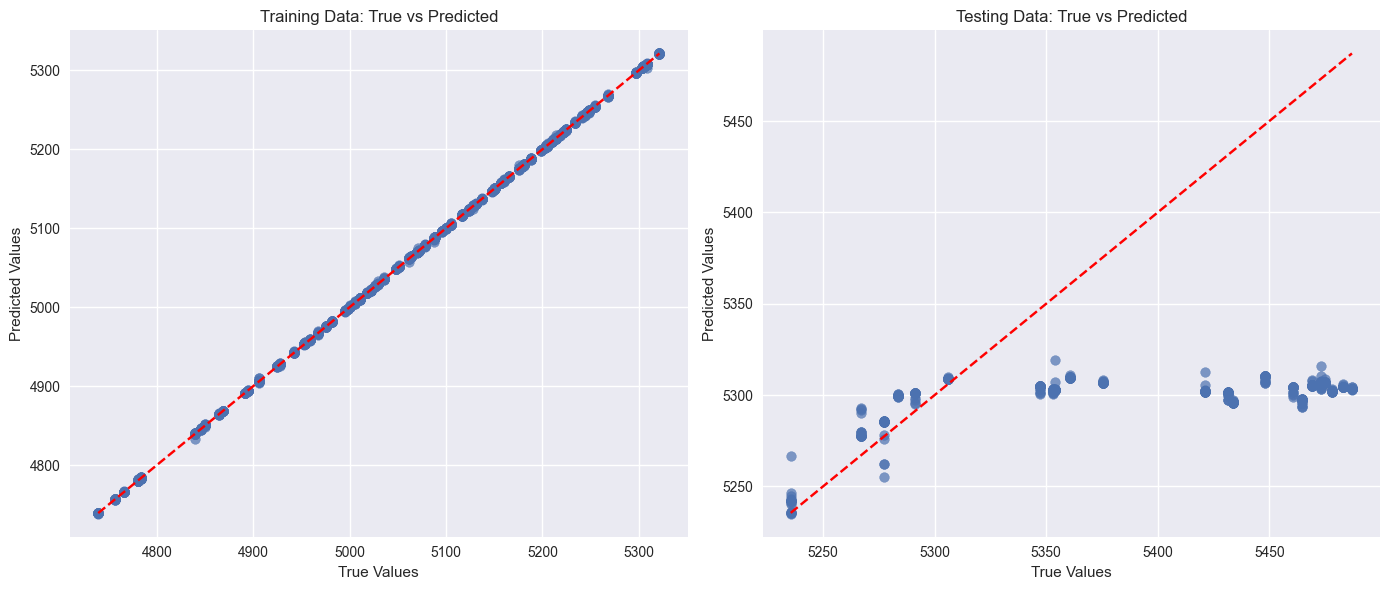

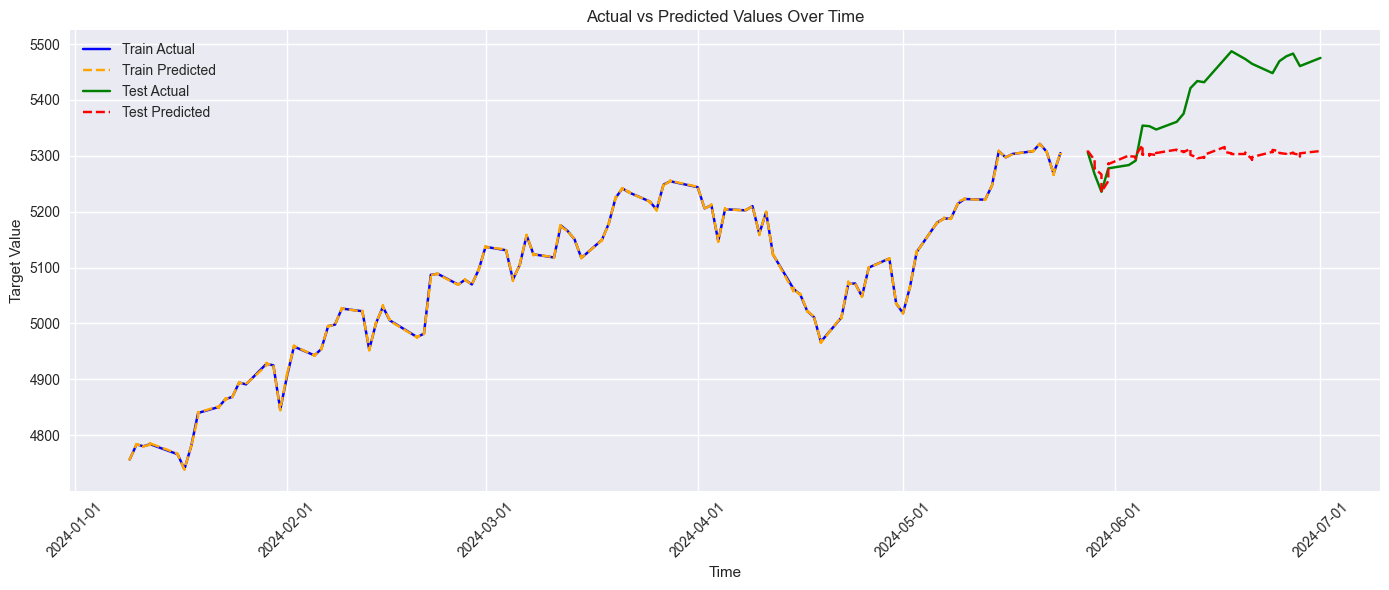

In [72]:
def train_and_evaluate_model(
    data: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = 'target',
    test_size: float = 0.1,
    random_state: int = 42
) -> Dict:
    """Train and evaluate XGBoost model with hyperparameter tuning."""
    # Separate features and target
    X = data[feature_cols]
    y = data[target_col]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    # Save testing dataset for reference
    X_test.to_csv("testing.csv", index=False)

    # Define the base XGBoost model
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=random_state
    )

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [200],
        'max_depth': [7, 10],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.9],
        'colsample_bytree': [0.6, 0.8],
        'min_child_weight': [3, 5, 7]
    }
    
    # Perform grid search
    tscv = TimeSeriesSplit(n_splits=5, gap=5)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=tscv,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print errors
    print("\nEvaluation Metrics:")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Plot results
    plt.figure(figsize=(14, 6))

    # Plot training predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.7)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.title("Training Data: True vs Predicted")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")

    # Plot testing predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title("Testing Data: True vs Predicted")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")

    plt.tight_layout()
    plt.show()

    # Plot results over time
    plt.figure(figsize=(14, 6))

    # Combine actual and predicted values for plotting
    train_indices = y_train.index
    test_indices = y_test.index
    train_indices = pd.to_datetime(train_indices)
    test_indices = pd.to_datetime(test_indices)

    plt.plot(train_indices, y_train, label="Train Actual", color="blue")
    plt.plot(train_indices, y_train_pred, label="Train Predicted", linestyle="--", color="orange")
    plt.plot(test_indices, y_test, label="Test Actual", color="green")
    plt.plot(test_indices, y_test_pred, label="Test Predicted", linestyle="--", color="red")

    plt.title("Actual vs Predicted Values Over Time")
    plt.xlabel("Time")
    plt.ylabel("Target Value")
    plt.legend()

    # Format the x-axis to prevent overlapping
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format x-axis as dates
    plt.tight_layout()
    plt.show()


    return {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Train and evaluate the model
print("\nTraining and evaluating model...")
model_results = train_and_evaluate_model(
    prepared_data,
    feature_cols,
    target_col='target',
    test_size=0.2
)
